In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import os
import time
from imagePreprocess import getImagesVarAndMean

In [ ]:
# TODO:
# less green
# try with sigmoid
%load_ext blackcellmagic
dataDir = "data/resized/"
biggerNet = True
depthMultiplier = 2
initializer = 'he_normal'#'glorot_uniform' ##
activation = 'relu'#LeakyReLU(alpha=0.3)
finalActivation = 'relu' # 'sigmoid'
normalize = finalActivation == 'sigmoid' # normalizing output hinders this training

In [ ]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
#     hue = K.square(huePred - hueTrue) 
    
    hue2 = K.minimum(K.square(huePred - hueTrue), 
                    K.minimum(K.square(huePred - hueTrue + maxHue), 
                              K.square(huePred - hueTrue - maxHue)))
    #hue = K.minimum((huePred + 181 - hueTrue) % 181, (hueTrue + 181 - huePred) % 181) #3
    #hue = K.square( (huePred - hueTrue) % 181 )
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)*2 + 1 # was /2
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    #hue = hue  + 1 / (huePred + 1)
    #hue2 = hue2  + 1 / (huePred + 1)
    return K.concatenate([hue2, saturation], axis=-1) # predictedHue was 0 when order is reversed

In [ ]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

In [ ]:
def loadImgHsv(path):
    '''
    returns X - value
            Y - (hue, saturation)
    '''
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, var, mean, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.hsstd = np.sqrt(var[...,:2])
        self.hsmean = mean[...,:2]
        self.vstd = np.sqrt(var[...,2])
        self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd # it doesn't like standardization 
        X = np.expand_dims(X, axis=len(X.shape))
        if normalize:
#             pass
            Y[...,0] /= 180 # was [0] by mistake
            Y[...,1] /= 255
#             X /= 255
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [14]:
params = {'dim': (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}
data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.1 # 0.1
trainSize = int(len(data_IDs)*trainSplitPercent)
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSplitPercent = 0.002 # 0.02
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))


training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)
print(params['mean'].shape)

dataset size 202599
train len 20259
val len 405
(32, 128, 128, 2)
(128, 128, 3)


In [9]:
def createModel(input_shape, bigger, mul, initializer, activation, finalActivation):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = activation, padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge7)
    #if bigger:
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    # todo change to sigmoid?
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(2, 1, activation = finalActivation, padding = 'same', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss='mean_squared_error',#customLoss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

unet_bigger_mul2_he_normal27-05-2019-01-11-22
Epoch 1/1
63/63 [==============================] - 19s 306ms/step - loss: 8306.4145 - mean_absolute_error: 65.5845 - mean_squared_error: 8306.4145 - val_loss: 4189.5764 - val_mean_absolute_error: 50.6806 - val_mean_squared_error: 4189.5762
predy 0.0 131.94263 50.252983 (1, 128, 128, 2)
hue: 0.0 85.31432 39.856045
sat: 0.0 131.94263 60.649925
predy uint8 0 131 49.7540283203125
hue uint8 0 85 39.3546142578125


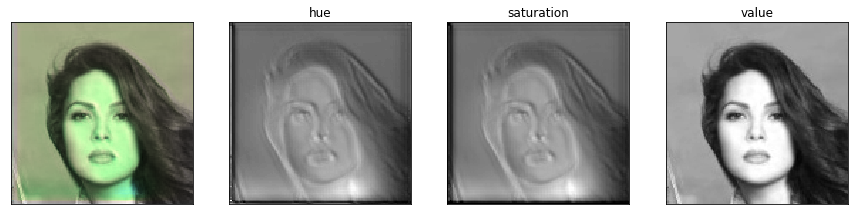

In [13]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
countEpochs = 1
#Compiling a model does not modify its state. Weights after compilation are the same as before compilation.
predictFromImage(f'data/resized/{trainSize:06}.jpg', True)

In [ ]:
# model.load_weights('data/unet_bigger_mul1_glorot_uniform13-05-2019-00-47-35.h5')
# countEpochs = 1

Epoch 12/12
633/633 [==============================] - 162s 257ms/step - loss: 2122.5164 - mean_absolute_error: 33.2855 - mean_squared_error: 2122.5164 - val_loss: 2189.2115 - val_mean_absolute_error: 33.3004 - val_mean_squared_error: 2189.2116
predy 9.17589 247.37662 61.169262 (1, 128, 128, 2)
hue: 9.17589 75.810814 27.99379
sat: 37.394688 247.37662 94.344734
predy uint8 9 247 60.66754150390625
hue uint8 9 75 27.49041748046875


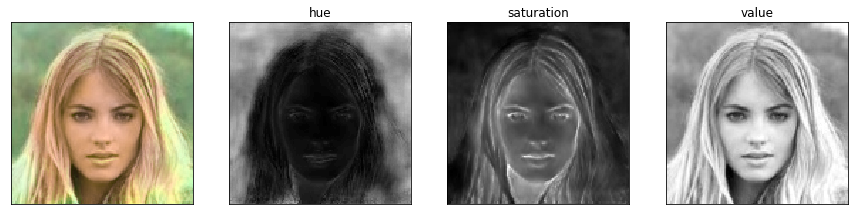

In [29]:
for i in range(1,2):
    #start_time = time.time()
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    #elapsed_time = time.time() - start_time
    #print(f"epochs:{countEpochs}, elapsed time:{elapsed_time}")
    predictFromImage(f'data/resized/{i+18:06}.jpg', True)

In [11]:
def mapOutOfGreen(m):
    '''maps green colors into others'''
    minGreen, maxGreen = 42, 63
    target = 160
    r = np.copy(m)
    r[(r >= minGreen) & (r<=maxGreen)] = (r[(r >= minGreen) & (r<=maxGreen)] - minGreen) +  target
    # smoother transition
    d = 7
    lower = minGreen - d
    sel = r[(r < minGreen) & (r>= lower)]
    r[(r < minGreen) & (r>= lower)] = (sel - lower) /d * (target - lower) + sel

    higher = maxGreen + d
    sel = r[(r > maxGreen) & (r<= higher)]
    r[(r > maxGreen) & (r<= higher)] = (sel - higher) /d * (target - higher) + sel
    return r

def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
#     h = mapOutOfGreen(h)
    #print('h',h.shape,'s',s.shape,'v',v.shape)
    #print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    # showHsv(hsv)    
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
        
    f, axarr = plt.subplots(1,4, figsize=(15,15))
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(img)
    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        #axarr.title(['hue', 'saturation', 'value'][i])
        axarr[1+i].title.set_text(['hue', 'saturation', 'value'][i])
        axarr[1+i].set_xticks([])
        axarr[1+i].set_yticks([])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    X, Y = validation_generator[1]
    #print('xshape',X.shape, 'yshape',Y.shape)

    inX, inY = loadImgHsv(img )
    inX, inY = inX[None,...,None], inY[None,:]
    X, Y = X[10][None,:], Y[0][None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)

    print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
    print('hue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    print('sat:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    if normalize:
        # hue and sat [0,1] -> their range
        predY[...,0] *= 180
        predY[...,1] *= 255
    else:
        predY[...,0] = predY[...,0] % 181
        predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    hue = predY[...,0]
    print('hue uint8',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        predictFromImage(f'data/resized/{i:06}.jpg', True)

countEpochs 12
predy 10.301591 258.54947 70.45846 (1, 128, 128, 2)
hue: 10.301591 115.31001 52.051044
sat: 13.541665 258.54947 88.86587
predy uint8 2 255 69.950439453125
hue uint8 10 115 51.55450439453125


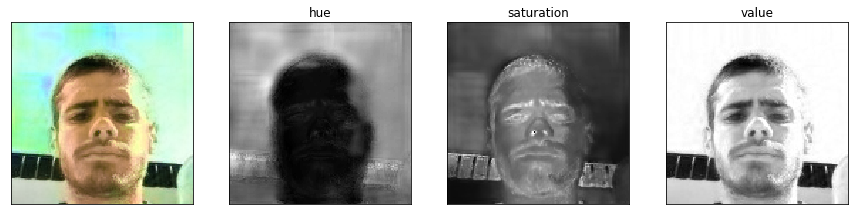

predy 6.8282123 279.17514 76.43652 (1, 128, 128, 2)
hue: 6.8282123 116.957016 49.357407
sat: 13.423783 279.17514 103.51564
predy uint8 4 255 75.89505004882812
hue uint8 6 116 48.85345458984375


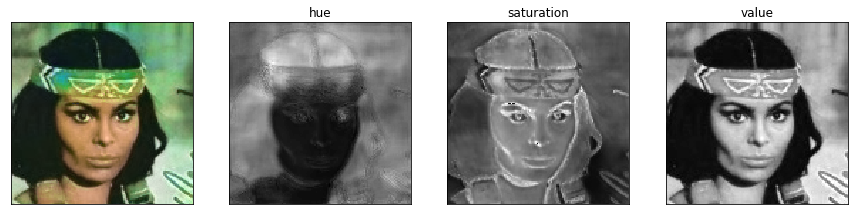

predy 7.0559654 232.1723 62.314804 (1, 128, 128, 2)
hue: 7.992249 78.28303 30.324429
sat: 7.0559654 232.1723 94.305176
predy uint8 7 232 61.81298828125
hue uint8 7 78 29.82122802734375


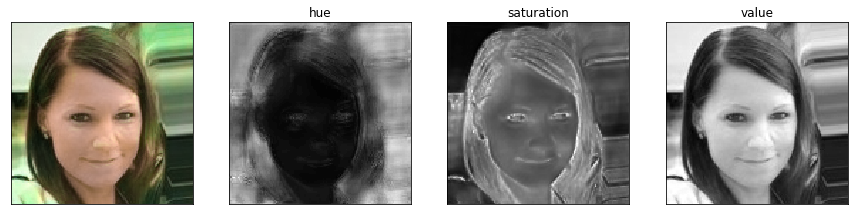

predy 7.200089 246.16797 68.422646 (1, 128, 128, 2)
hue: 7.200089 95.97361 40.49774
sat: 15.44693 246.16797 96.34755
predy uint8 7 246 67.92153930664062
hue uint8 7 95 39.99468994140625


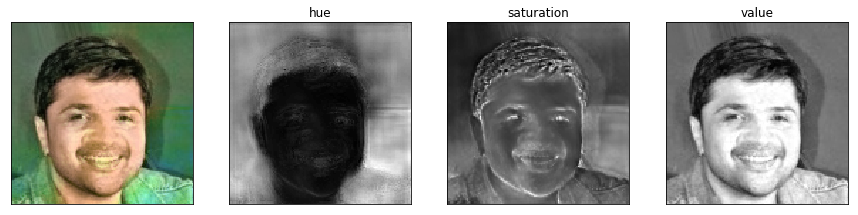

predy 8.78804 262.87656 77.08647 (1, 128, 128, 2)
hue: 8.78804 110.124855 32.63324
sat: 47.75657 262.87656 121.53972
predy uint8 0 254 76.55484008789062
hue uint8 8 110 32.13037109375


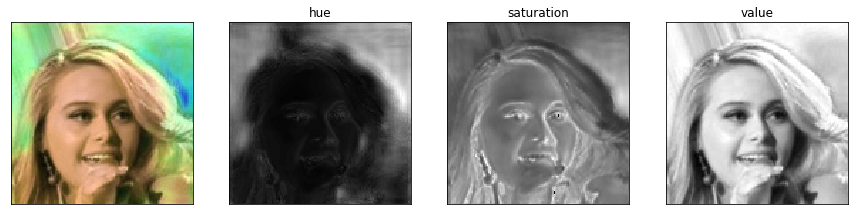

predy 7.904893 237.25223 66.80181 (1, 128, 128, 2)
hue: 7.904893 70.66408 33.082638
sat: 15.092703 237.25223 100.52097
predy uint8 7 237 66.302978515625
hue uint8 7 70 32.581298828125


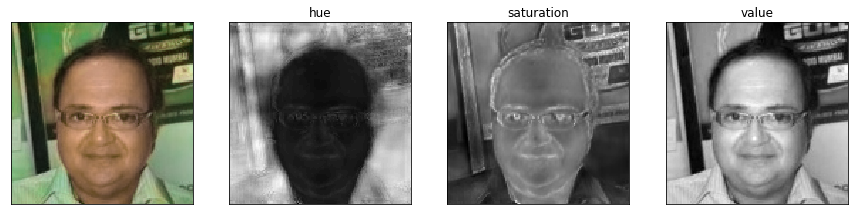

predy 9.671613 244.82881 77.663315 (1, 128, 128, 2)
hue: 9.671613 64.53306 28.498697
sat: 58.258774 244.82881 126.82794
predy uint8 9 244 77.16445922851562
hue uint8 9 64 27.99761962890625


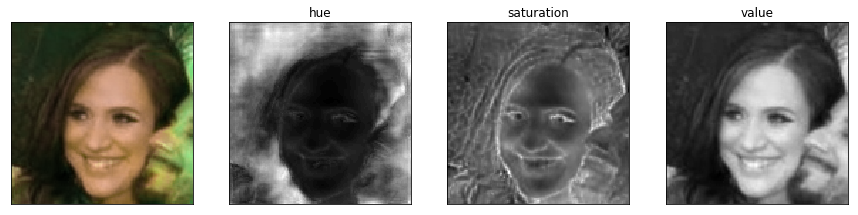

predy 9.65217 294.99075 73.31 (1, 128, 128, 2)
hue: 9.65217 76.17374 27.593521
sat: 24.319601 294.99075 119.02649
predy uint8 0 254 72.534912109375
hue uint8 9 76 27.09228515625


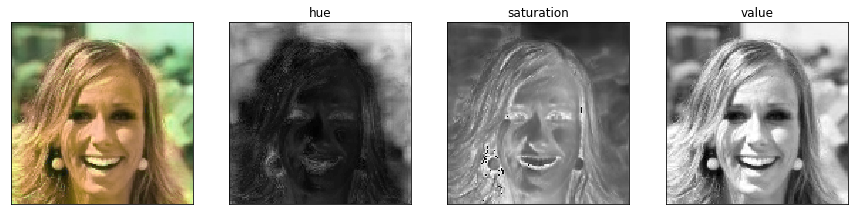

predy 3.3606052 301.88135 73.66768 (1, 128, 128, 2)
hue: 3.3606052 91.73298 36.08914
sat: 9.877287 301.88135 111.2462
predy uint8 1 254 72.97998046875
hue uint8 3 91 35.590087890625


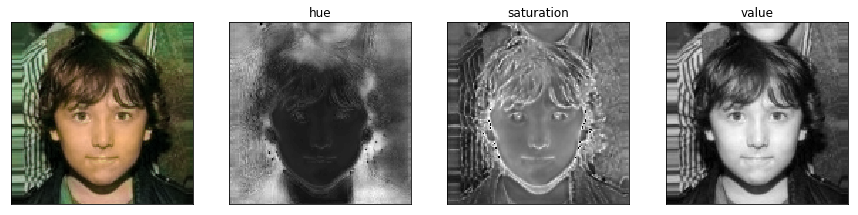

predy 10.144705 303.28098 91.125854 (1, 128, 128, 2)
hue: 10.144705 109.82999 46.654106
sat: 57.474556 303.28098 135.5976
predy uint8 1 255 90.25381469726562
hue uint8 10 109 46.1568603515625


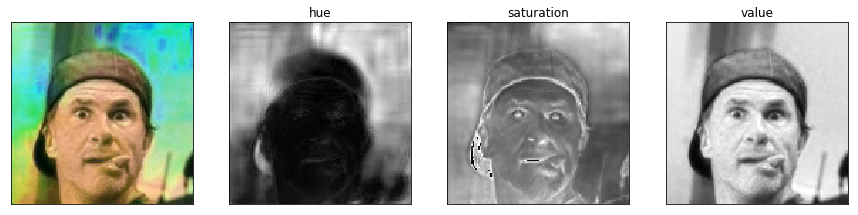

In [35]:
print('countEpochs',countEpochs)
predictions(trainSize, 10)


In [ ]:
def nonMlBaseline():
    x = training_generator[33][0][0,...,0]
    y = np.dstack([params['mean'][...,0].astype('uint8'), params['mean'][...,1].astype('uint8'), x.astype('uint8')])
    #print(y.shape, params['mean'][...,0].min(), params['mean'][...,0].max(), x.dtype, x.min(), x.max())
    # plt.imshow(x - params['mean'][...,2])
    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['hue','saturation','value'][i-1])
        plt.imshow(params['mean'][...,i-1])
    plt.show()
    print("Input value with mean hue and mean saturation:")
    showHsv(y)
nonMlBaseline()

In [ ]:
print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

In [21]:
model.save(f'data/{NAME}.h5')

In [ ]:
print(training_generator[0][0][0,...,0].shape)
print('sanity check - mean[...,2] is val mean:')
ttt =(training_generator[0][0][6,...,0] - params['mean'][...,2]  ) / np.sqrt(params['var'][...,2])
plt.imshow(ttt) 
ttt.min(), ttt.max(), ttt.mean()

In [ ]:
print('mean hue, saturation, value:')
h,s,v = params['mean'][...,0], params['mean'][...,1], params['mean'][...,2]
showHsv(np.dstack([h,s,v]).astype('uint8'))
for i,c in enumerate([h,s,v]):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(c)

plt.show()


In [ ]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
batch=55
print('testing channel ranges:')
print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
print(training_generator[batch][1].shape)
h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
v = training_generator[batch][0][0,...].astype('uint8')
y = np.dstack([h , s, v ] )
showHsv(y )
print(h.min(), h.max())
plt.imshow(h)

In [ ]:
x1w = model.get_weights()[0][:,:,0,:]
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()